# Objective
In this workbook, I use Python and pandas to explore 1.6MM observations from The Lending Club data, which Nathan George has kindly provided on Kaggle. This is an interesting dataset not only because of its sheer size, but because it includes much information about the borrowers, such as borrowers' current balance, FICO score, income, etc. This dataset is very similar to the Prosper dataset, but it is of a much larger size.

This notebook's main purpose is exploration. I do not seek to optimize for the performance metrics, but only want to explore the certain techniques, such as feature selection, sampling methods, etc.

The layout of this Notebook is as follows:
-  Simple data cleaning
-  Data Exploration
> Change of rates through time <br>
> Distribution of Income across grade <br>
> Income distribution by professions <br>
> FICO range and grade <br>
> Charge-off rate vs Verification status
-  Simple feature selection using GBM and Random Forest
-  Model run using a combination of:
> GBM, Random Forest, Logistic Regression, Mas-o-menos <br>
> StandardScaler, Scaler from Airbnb <br>
> SMOTE, RandomUnderSampling <br>


In [243]:
%matplotlib inline
import os 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.externals import joblib
from xgboost import XGBClassifier


ROOT_PATH = '../'
accepted = pd.read_csv(ROOT_PATH + './input/accepted_2007_to_2017.csv')

Let's check the size of the data

In [244]:
accepted.shape

(726878, 84)

This dataset includes 1.6MM observation with 150 features. Let's check for missing values. I was itching to explore some questions I already have for the data, so I decided to ignore columns where there are a large number of missing values instead of imputing them.

In [ ]:
missing_data = accepted.isnull().sum().sort_values(ascending= False)
drop_columns = list(missing_data[missing_data > accepted.shape[0] *0.1].index) # drop columns where at least 10% of data is missing
accepted = accepted.drop(drop_columns, axis = 1)

missing_data

Since The Lending Club was launched in 2012, there may have been significant changes in its loan portfolios since then. The code transforms the issue date of the loans so that we have use them in further analysis. 

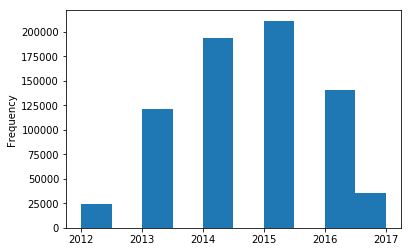

In [245]:
accepted.term = accepted.term.apply(str)
accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])

accepted.issue_d = pd.to_datetime(accepted.issue_d)
accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['issue_yr'].plot.hist()

# Data transformation
I decide to drop several columns because they are a linear combination of others, or they contain too little information.
As for Zip Code, we only have the first 3 number so this feature is not helpful.

In [ ]:
accepted = accepted.drop(['title', 'funded_amnt'], axis = 1)
accepted = accepted.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)
accepted = accepted.drop(['fico_range_low', 'last_fico_range_low',
                         'avg_cur_bal',
                         'addr_state', 'initial_list_status', 'pymnt_plan',
                         'application_type', 'hardship_flag', 'disbursement_method',
                          'debt_settlement_flag','sub_grade',
                         'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)


I transform a few variables into the date type for easier analysis later

In [ ]:
accepted.home_ownership = accepted.home_ownership.replace(['ANY', 'NONE','OTHER'], 'RENT')

accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['earliest_cr_line'] = pd.to_datetime(accepted.earliest_cr_line)
accepted['early_cr_yr'] = accepted.earliest_cr_line.dt.year

median_year = accepted.emp_length.value_counts(ascending = False).index[0]
accepted.loc[:, 'emp_length'] = accepted.loc[:, 'emp_length'].fillna(median_year)

accepted.emp_length = accepted.emp_length.replace(['10+ years'], '10 years')
accepted.emp_length = accepted.emp_length.replace(['< 1 year'], '0 years')

accepted.emp_length = accepted.emp_length.apply(lambda x: int(str(x).split(' ')[0]))
print(accepted.emp_length.value_counts())

accepted.loc[:, 'emp_title'] = accepted.loc[:, 'emp_title'].fillna('other')
accepted.emp_title = accepted.emp_title.apply(lambda x: x.lower())
accepted.emp_title = accepted.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')

# Exploration Questions
## Change of rates through time
Each loan receives a grade that ranges from G through A. Starting November 2017, grade F and G are no longer used. These codes will plot the average interest rate according to grate through time.

In [ ]:
rate = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
rate.shape # 77, 1
rate = rate.reset_index()

Text(0.5,0.98,'Interest Rate over time and grade')

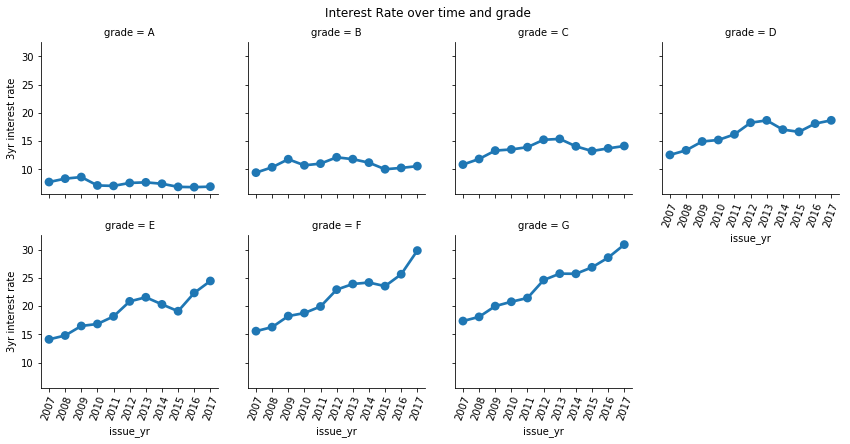

In [246]:
g = sns.FacetGrid(rate, col = 'grade', col_wrap = 4)
g = g.map(sns.pointplot, "issue_yr", "int_rate")

labels = np.arange(2007, 2018, 1)
labels = [str(i) for i in labels]
g = g.set_xticklabels(labels, rotation=70)
g = g.set_ylabels("3yr interest rate")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Interest Rate over time and grade')

We can see that interest rate for grade D, E, F, G increase quickly from 2014. 

We have very few data points from 2007 to 2014. Let's take a closer look to see if this increase in average rate is not due to the small number of observations.


In [247]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

int_rate                                      
grade           A      B      C      D     E     F    G
issue_yr                                               
2012         4052   7893   4765   2474   369    42    6
2013        16702  38766  23084  13086  2761   480   12
2014        34088  49466  38410  17970  6274  1730  153
2015        33963  46185  41858  18555  5762   861  161
2016        18220  34585  32243  14914  4488  1208  297
2017         4273   7692   8624   4123  1596   383  197

The number of loans has increased almost exponentially since inception (which is actually 2007).

## Borrowing purpose

In [248]:
accepted.purpose.value_counts().sort_values(ascending=False)

debt_consolidation    438308
credit_card           158261
home_improvement       44611
other                  36795
major_purchase         13968
medical                 7501
small_business          7230
car                     6447
moving                  4786
vacation                4368
house                   3369
wedding                  783
renewable_energy         450
educational                1
Name: purpose, dtype: int64

## Distribution of Income across Grade
Let's take a leap of faith and only examine the loans where income has been verified. The variable *verification status* can take one of 3 values: Verified, Source Verified or Not Verified. Here I only filtered for loans whose *verification status* is different from 'Not Verified'.

I put a cap on the high income (95% percentile), because the high income level can be in the amount of $500,000, which is not that regular and will distort the chart.

In [ ]:
incomeVerified = accepted[accepted['verification_status'] != 'Not Verified'].dropna()
incomeVerified = incomeVerified[['grade','annual_inc']]
quantile_low = incomeVerified['annual_inc'].min()
quantile_high = incomeVerified['annual_inc'].quantile(0.95)
filtered = incomeVerified[(incomeVerified['annual_inc'] > quantile_low) & (incomeVerified['annual_inc'] <= quantile_high)]

(0.0, 2e-05)

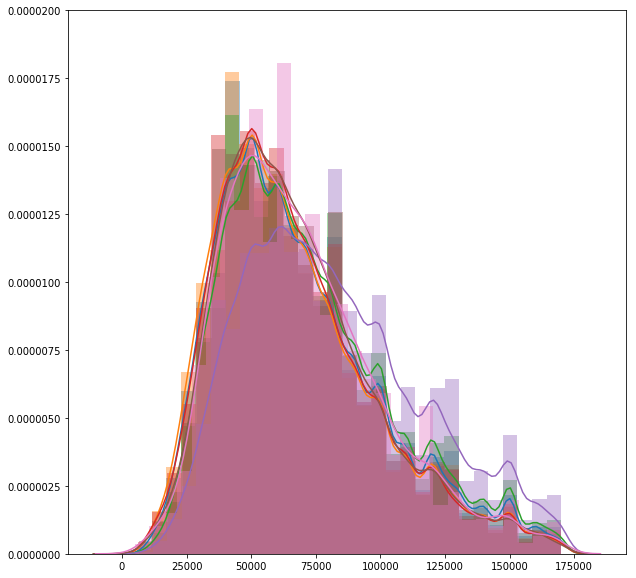

In [249]:
grade_list = filtered['grade'].unique()
plt.figure(figsize=(10,10))
for i in range(len(grade_list)):
    data = filtered[filtered['grade'] == grade_list[i]]['annual_inc'].values
    sns.distplot(data, bins = 30)

plt.ylim(ymax = 0.00002)

There seems to be a slight difference in income level across grade, with one grade has a high density of income above $100,000. Perhaps it may not be beneficial to dive too deep into it, except having a brief look at the median income accross each grade. We do see that while other grades seem to have similar median incomes, grade A does stand out.

In [250]:
# Median of incomes in each grade
income_median = pd.pivot_table(filtered, values = 'annual_inc', index = 'grade', aggfunc = np.median)
income_median

,annual_inc
grade,
A,"75,600.00"
B,"65,000.00"
C,"62,000.00"
D,"60,000.00"
E,"60,320.00"
F,"62,400.00"
G,"65,000.00"


## Income Distribution by Professions

Because of the large number of observations that we have, we can construct a reliable distribution of annual incomes.But first, further transformation:
- Filtering for loans where the reported income is less than 1 million USD
- Filtering for loans where Debt-to-Income ratio is less than 100 percent. If it is greater than or equal to 100, I wonder why we would have made such loans in the first place. I could have been more careful by capping dti value at 100. 
- Changing employment years into numeric
- Filling unknown values for home-ownership as Rent
- Standardizing the values of employment title (emp_title)

In [ ]:
leq1mil = accepted['annual_inc'] <= 1e6
accepted = accepted[leq1mil]
accepted = accepted[accepted.dti < 100.0]

 Because people will most likely lie on their incomes when their income is low, we can filter out for data if:
* Income is lower than \$70,000 but has been verified by Lending Club
* Income is higher than \$70,000 but lower than \$120,000
* Income is higher than \$120,000 but has been verified by Lending Club

The choice of limit of \$70,000 and \$120,000 is arbitrary to filter out loans where income levels seem unrealistic. 

In [251]:
pd.options.display.float_format = '{:,.0f}'.format
salary_limit = 7e4

emp_annual_all = accepted.loc[((accepted['annual_inc'] >= 1.2e5) & (accepted['verification_status'] == 'Verified')) 
                              | ((accepted['annual_inc'] >= salary_limit) & (accepted['annual_inc'] < 1.2e5)) 
                              | ((accepted['annual_inc'] < salary_limit) & (accepted['verification_status'] == 'Verified')),
                              ['emp_title','annual_inc']].groupby('emp_title')


summ_inc = emp_annual_all.agg(['min','mean','median','max', 'count'])
summ_inc.columns = summ_inc.columns.levels[1]
summ_inc = summ_inc.sort_values(by = ['count','min'], ascending = False)

# Filter for professions with more than 500 observations
summ_inc = summ_inc[summ_inc['count'] >= 500].sort_values(by = ['count','min'], ascending = False)
summ_inc

,min,mean,median,max,count
emp_title,,,,,
other,"3,000","54,873","48,500","920,000",30470
nurse,"10,900","83,905","80,000","320,000",9149
manager,"10,000","84,465","81,500","1,000,000",7246
teacher,"11,000","74,403","75,000","367,500",6626
supervisor,"14,900","76,934","75,000","225,000",3239
owner,"8,436","91,418","83,416","900,000",3134
driver,"10,000","73,518","75,000","1,000,000",2929
project manager,"22,000","92,245","90,000","341,000",2882
sales,"12,000","87,887","80,000","600,000",2876


This dataset does have a large diversity in the professions and income level of borrowers. Personally, what I find most interesting is that:

- Teacher and Nurse, despite being regarded as respectable professions in some regions in the world, are the 2 most common professions on Lending Club. Their minimum salary is only around \$12,000, which is lower than US' Poverty Level for individual.
- Police officer has a minimum salary of \$32,000
- Many people with annual income higher than \$400,000 and even \$1,000,000 still use Lending Club as a way to borrow cheaply. I can dive down into the purpose of the loans later, but that may not offer much benefit for data modeling.
- Some job traditionally associated with high income has very min income, such as attorney, director, enginee. And these salaries have been verified by Lending Club. It's likely that these salaries miss a 0's. This is worthy of attention.

## Fico range and grade
As we have seen in the previous workbook, income distribution is similar across loan grade while income for grade A is a little bit higher.

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


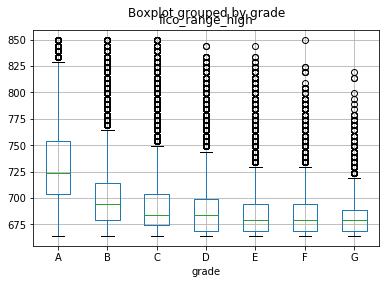

In [252]:
accepted.boxplot(by = 'grade', column = 'fico_range_high')

The change in FICO score may be associated with the loans. While I cannot observe how FICO will change over time, it will be an interesting visualization. 

## Charge off rate vs Verification status
My hypothesis is that Lending Club tends to take the effort to verify a borrower's income only when it is _high_. To quickly examine this hypothesis, I look at the charge off rate across each grade depending on whether the income is Verified or not.

I define that a loan is considered charge-off when the value of *loan_status* is Charged Off or Default. I can expand it to 90 days behind dues, but it does not make that large of a difference.

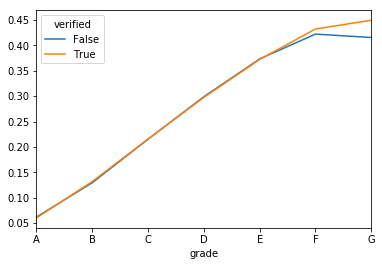

In [253]:
accepted['verified'] = accepted['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(accepted,index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(accepted[(accepted.loan_status == 'Charged Off') | (accepted.loan_status == 'Default')],
                                           index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default.columns = ['Charged_off']

loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)
loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['loan_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()


Based on the graph, we can safely reject my hypothesis. Loans that have verified income actually has a high level of charge-off. It is reasonable to assume that these loans are often associated with lower level of income, hence higher charge-off. 

The graph also show that the charge-off rate changes almost linearly from grade A (highest grade) through grade G. The charge-off rate for grade F-G is approximately 25%. To compare, this is still lower than that historic default rate of non-investment grade bond, which is higher than 30% ([Wikipedia Credit Rating](https://en.wikipedia.org/wiki/Bond_credit_rating).)


# Modeling
With the status of being a Good or Bad Loan our variable of interest, we can approach this as a classification problem. This is still an exploratory phase so please excuse the haphazard approach. First, define our target:

In [ ]:
accepted.loan_status.value_counts()

In [ ]:
accepted = accepted.loc[accepted.loan_status != 'Current', :]
accepted['target'] = 1
accepted.loc[(accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'In Grace Period') 
             | (accepted.loan_status == 'Does not meet the credit policy. Status:Fully Paid')
                , 'target'] = 0

Let's see the columns that we have:

In [ ]:
accepted.columns

Generally, *bc* stands for bank cards. *il* stands for installment.
*num_actv_bc_tl* is number of active bank card accounts.

I calculate a few more variables:
- *Balance_annual_inc* is the ratio of current balance over annual income, similarly for *install_annual*.
- *install_loan_ratio* is the ratio of monthly installment / loan amount. This should be very similar to rate, and therefore to the grade of the loan
- *disposable_inc* is the amount of disposable income each month after mortgage payment and payment for Lending Club loans
- *dti_new* is *disposable_inc* \* 12 / *annual_inc*

I plan to approach using a series of tree-model, which does not handle well the difference and interaction between features. 

In [ ]:
accepted.isnull().sum().sort_values(ascending=False)

In [ ]:
accepted = accepted.dropna()
accepted.shape

In [ ]:
# Assuming that if borrowing for debt consolidation, they actually have more disposable income
accepted.loc[:, 'temp'] = np.where((accepted.purpose == 'debt_consolidation') | (accepted.purpose == 'credit_card'),0.5, -1.0)
accepted.loc[:, 'disposable_inc'] = (1 - accepted['dti']/100)*accepted['annual_inc']/12 + accepted['temp'] * accepted['installment']    
accepted.loc[:, 'disposable_ratio']= accepted['disposable_inc']*12/ accepted['annual_inc']

accepted.drop('temp', axis = 1)

accepted.loc[:, 'cr_yr_before_loan'] = accepted['issue_yr'] - accepted['early_cr_yr']

accepted['log_annual_inc'] = np.log(accepted.annual_inc)
accepted['log_installment'] = np.log(accepted.installment)

accepted['install_loan_ratio'] = accepted['installment'] / accepted['loan_amnt']
accepted['balance_annual_inc'] = accepted['loan_amnt'] / accepted['annual_inc']
accepted['install_annual'] = accepted['installment'] / accepted['annual_inc']

In [ ]:
selected_features = ['loan_amnt', 'term', 'int_rate', 'installment'
            # , 'grade' - grade is dropped because it is highly correlated with int_rate
            ,'emp_length', 'home_ownership', 'annual_inc', 'verification_status'
            # ,'issue_d'
            # , 'purpose'
            ,'dti', 'delinq_2yrs'
            ,'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal'
            ,'revol_util', 'total_acc'
            #, 'out_prncp', 'total_pymnt', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee'
            #,'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
            #,'last_fico_range_high', 'collections_12_mths_ex_med', 'acc_now_delinq'
            #,'tot_coll_amt', 
            ,'tot_cur_bal', 'total_rev_hi_lim','acc_open_past_24mths', 'bc_open_to_buy', 'bc_util'
            ,'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct'
            ,'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl'
            ,'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd'
            ,'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl'
            ,'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0'
            ,'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m'
            ,'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'
            ,'pub_rec_bankruptcies', 'tot_hi_cred_lim'
            ,'total_bal_ex_mort'
            ,'total_bc_limit', 'total_il_high_credit_limit'
            #,'issue_yr'
            #,'earliest_cr_yr'
            ,'loan_status','target'
            ,'cr_yr_before_loan'
            ,'log_annual_inc', 'log_installment'
            ,'disposable_inc', 'install_loan_ratio', 'disposable_ratio', 'balance_annual_inc'
            ,'install_annual']

Create testing and training set: I can use train_test_split, but I decide to be more realistic and see what happen if I use the training data until 2016 and test on the data in 2017. In reality, there should probably be another validation set, for example: training data only lasts until 2015, then 2016 data is used as validation. 

In [ ]:
accepted_train_clean = accepted.loc[(accepted.issue_yr != 2017) | (accepted.issue_yr != 2016), :]
accepted2017_clean = accepted.loc[(accepted.issue_yr == 2017) | (accepted.issue_yr == 2016), :]
print("Training size", accepted_train_clean.shape)
print("Testing size", accepted2017_clean.shape)

In [ ]:
## In my experiments, I actually output these 2 datasets so that 
## I can come back to them with ease instead of having to run the whole workbook again
accepted_train_clean.to_csv(ROOT_PATH + './input_clean/train.csv', index = False)
accepted2017_clean.to_csv(ROOT_PATH + './input_clean/test.csv', index = False)

In [100]:
accepted_train_clean = pd.read_csv(ROOT_PATH + './input_clean/train.csv', encoding = "ISO-8859-1")
accepted2017_clean = pd.read_csv(ROOT_PATH + './input_clean/test.csv', encoding = "ISO-8859-1")

## Helper function
Define a few helper function:

In [106]:
def GetAUC(model, X_train, y_train, X_test, y_test):
    '''
    To quickly get the AUC of model on the training and testing set
    '''
    res = [0.0, 0.0]
    y_train_score = model.predict_proba(X_train)[:, 1]
    res[0] = metrics.roc_auc_score(y_train, y_train_score)
    print("In sample", res[0])
    
    y_test_score = model.predict_proba(X_test)[:, 1]
    res[1] = metrics.roc_auc_score(y_test, y_test_score)
    print("Out of sample", res[1])
    
def GetXY(df, features):
    '''
    Select the subset of features
    Create dummy variables if needed
    '''
    df = df.loc[:, features]

    categorical_features = ['term', 'home_ownership', 'verification_status']
    
    for cat_feature in categorical_features:
        if cat_feature in df.columns:
            df = pd.get_dummies(df, prefix = [cat_feature], columns = [cat_feature], drop_first = True)
            
    X = df.drop(['loan_status', 'target'], axis = 1)
    y = df.target
    
    return X, y

In [107]:
X, y = GetXY(accepted_train_clean, selected_features)
X_test, y_test = GetXY(accepted2017_clean, selected_features)

print(X.shape)
print(X_test.shape)

# The difference in shape is fixed later
# X has an extra column: home_ownership_OTHER

(726878, 62)
(176608, 61)


In [254]:
set(X.columns.values)-set(X_test.columns.values)

In [109]:
# X_test['home_ownership_OTHER'] = 0

## Baseline model
Please follow Vince Poceta's workbook. I expected the AUC to be around 0.65.

## Simple feature selection
I feel that 100 features are too much for this kind of problem. I will attempt to fit Gradient Boosting and Random Forest on this data as some form of simple Feature Selection method. There are other established methods, like Boruta, but the computation is also much more.

In [110]:
gbm = GradientBoostingClassifier(max_depth = 6, n_estimators= 400, max_features = 0.3)
gbm.fit(X, y)
GetAUC(gbm, X, y, X_test, y_test)

In sample 0.765938306371
Out of sample 0.747767813214


In [111]:
rfc = RandomForestClassifier(max_depth = 6, n_estimators= 400, class_weight = {0: 1, 1:10})
rfc.fit(X, y)
GetAUC(rfc, X, y, X_test, y_test)

In sample 0.765938306371
Out of sample 0.747767813214


In [112]:
joblib.dump(gbm, ROOT_PATH + './model_run/gbm.pkl')
joblib.dump(rfc, ROOT_PATH + './model_run/rfc.pkl')

['.././model_run/rfc.pkl']

Let's check the feature importance from these 2 models. I mainly pay attention to *Max of feature importance* divided by the feature importances. As such, the feature with the highest feature importance will receive a value of 1, and the feature will lowest feature importance will receive a large value.

In [113]:
pd.options.display.float_format = '{:,.2f}'.format
feature_imp = pd.DataFrame({'name': X.columns, 'imp': gbm.feature_importances_}).sort_values(by = 'imp', ascending = False)

feature_imp['mult_gbm'] = feature_imp.imp.max() / feature_imp['imp']
feature_imp['mult_rfc'] = rfc.feature_importances_.max() / rfc.feature_importances_

feature_imp.to_csv(ROOT_PATH + './model_run/feature_importance.csv')
feature_imp

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


,imp,name,mult_gbm,mult_rfc
52,0.06,install_loan_ratio,1.00,35.09
1,0.06,int_rate,1.07,1.00
53,0.04,disposable_ratio,1.64,57.82
5,0.03,dti,2.00,"5,856.15"
22,0.03,mo_sin_old_rev_tl_op,2.24,56.45
54,0.03,balance_annual_inc,2.25,7.19
11,0.03,revol_bal,2.34,752.81
21,0.03,mo_sin_old_il_acct,2.50,3.47
55,0.02,install_annual,2.64,263.41
47,0.02,total_il_high_credit_limit,2.69,665.59


From testing the model, I feel that GBM can easily overfit the data, plus the feature importance from GBM mostly make sense, so I put my faith in this. 

Even though I should not pay too much attention in the scale of the feature importance, I feel that a difference of 6 times in magnitude may signify something, so I only select a subset 

In [114]:
selected = feature_imp.loc[feature_imp.mult_gbm < 6, ['name','mult_gbm']]
X_reduced = X[selected.name.values]
X_test_reduced = X_test[selected.name.values]

X_reduced.shape
X_reduced.columns

Index(['install_loan_ratio', 'int_rate', 'disposable_ratio', 'dti',
       'mo_sin_old_rev_tl_op', 'balance_annual_inc', 'revol_bal',
       'mo_sin_old_il_acct', 'install_annual', 'total_il_high_credit_limit',
       'disposable_inc', 'tot_hi_cred_lim', 'tot_cur_bal', 'bc_util',
       'revol_util', 'bc_open_to_buy', 'total_rev_hi_lim', 'total_bc_limit',
       'installment', 'total_bal_ex_mort', 'log_annual_inc',
       'cr_yr_before_loan', 'annual_inc', 'mths_since_recent_bc',
       'log_installment', 'acc_open_past_24mths', 'pct_tl_nvr_dlq',
       'fico_range_high', 'total_acc', 'loan_amnt', 'num_il_tl', 'emp_length',
       'num_rev_accts', 'mo_sin_rcnt_rev_tl_op', 'num_bc_tl',
       'num_rev_tl_bal_gt_0', 'mort_acc'],
      dtype='object')

## Model

It appears that we no longer have any categorical data such as Homeownership. Now I attempt a series of test to see if I can improve the model's AUC. In practice, I should pay attention to other criteria such as F1 and recall as well. The list of models that I have tried:
- Logistic Regression: both used in Google and Facebook's CTR prediction 
- GBM: the work horse, I can over fit the data and see what may happen
- Mas-o-Menos: simple classification techniques by researchers at Harvard University. I read about this technique in the paper 50 years of Data Science as  an illustration of a simple, effective techique that trumps many other complicated algorithms in practice. Not surprisingly, this simple technique performs quite well for this dataset.
- Scale the data in multiple way:
> Standard Scaler: which I am very skeptical of if I have any categorical data <br>
> a Scaling method from Airbnb <br>
> Combination between Scaling and Over / Undersampling <br>


In [119]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

class MasOrMenos(BaseEstimator):
    def __init__(self):
        self.NumFeatures = 0
        self.coeffs = None
        self.model = LogisticRegression()
        
    def fit(self, X_train, y_train):
        self.NumFeatures = X_train.shape[1]
        sqrtNumFeatures = np.sqrt(self.NumFeatures)
        self.coeffs = [0.0] * self.NumFeatures
        for i in range(self.NumFeatures):
            self.model.fit(X_train.iloc[:, i:(i+1)], y_train)
            self.coeffs[i] = np.sign(self.model.coef_[0]) / sqrtNumFeatures
        
        self.coeffs = np.array(self.coeffs).reshape(-1,1)
    
    def sigmoid(self, x):
        return (1/ (1 + np.exp(-x)))

    def predict_proba(self, X_test):
        tmp = np.zeros((X_test.shape[0], 2))
        tmp[:, 1] = self.sigmoid(np.matmul(X_test, self.coeffs))[:,0]
    
        return tmp
    
    def predict(self, X_test):
        return self.predict_proba(X_test)[:, 1]

In [229]:
modelList = {'mm': MasOrMenos()
             ,'rfc': RandomForestClassifier(n_estimators= 300, max_depth = 5, class_weight = {0: 1, 1:10})
             ,'logistic': LogisticRegression()
             ,'logistic_l1_05': LogisticRegression(penalty='l1')
             ,'logistic_l1_4': LogisticRegression(penalty='l1', C = 4.0)
             ,'gbm': GradientBoostingClassifier(max_depth = 5, n_estimators= 300, subsample = 0.8, max_features = 0.5)
             #,'gbm_overfit': GradientBoostingClassifier(max_depth = 10, n_estimators= 300,
#subsample = 0.8, max_features = 0.5)
             ,'xgb': XGBClassifier(max_depth = 10, n_estimators = 200)
            }

### Rescaling
I attempt a feature engineering method from Airbnb [here](https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba) and transform all features into 0 and 1 scale, basically:
$$x\Rightarrow Pr(X \leq x \| Y = 1)$$
Luckily, my reduced set of features are all numerical. 

In [121]:
### Standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardScaled = scaler.fit_transform(X_reduced)
X_test_standardScaled = scaler.transform(X_test_reduced)

In [124]:
### Airbnb Scaler
X_reshaped_target = X_reduced[y == 1]
print("Shape of the referenced dataset", X_reshaped_target.shape)

def Transform_to_CDF(data_, compare):
    data_sorted = data_.sort_values()
    data = data_sorted.values
    
    compare = compare.sort_values().values
    output = [0] * len(data)
    idx_data = 0
    idx_compare = 0
    loop = True
    
    tmp = 0
    
    while loop:
        if idx_compare == len(compare):
            if idx_data < len(data):
                for i in range(idx_data, len(data)):
                    output[i] = tmp    
            break
        if idx_data == len(data):
            break
        if data[idx_data] < compare[idx_compare]:
            output[idx_data] = tmp
            idx_data += 1
        else:
            tmp += 1
            idx_compare += 1
    
    output = pd.Series(output, index = data_sorted.index)
    return output[data_.index]

X_bnbScaled = X_reduced.copy()
for i in range(X_reduced.shape[1]):
    X_bnbScaled.iloc[:, i] = Transform_to_CDF(X_reduced.iloc[:, i], X_reshaped_target.iloc[:, i])
X_bnbScaled = X_bnbScaled / X_reshaped_target.shape[0]

X_test_bnbScaled = X_test_reduced.copy()
for i in range(X_test_reduced.shape[1]):
    X_test_bnbScaled.iloc[:, i] = Transform_to_CDF(X_test_reduced.iloc[:, i], X_reshaped_target.iloc[:, i])
X_test_bnbScaled = X_test_bnbScaled / X_reshaped_target.shape[0]

Shape of the referenced dataset (169658, 37)


In [125]:
### Apply sampling method
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# SMOTE takes a lot of time to create
# I suggest not using smote at all
smote = SMOTE(random_state=1234)
underSampler = RandomUnderSampler(random_state=1234)

start = time.time()
X_standardScaled_smote, y_standardScaled_smote = smote.fit_sample(X_standardScaled, y)
X_bnbScaled_smote, y_bnbScaled_smote = smote.fit_sample(X_bnbScaled, y)

print("Smote time", (time.time()-start)/ 60)

X_standardScaled_underSample, y_standardScaled_underSample = underSampler.fit_sample(X_standardScaled, y)
X_bnbScaled_underSample, y_bnbScaled_underSample = underSampler.fit_sample(X_bnbScaled, y)

In [135]:
print(X_standardScaled_smote.shape, y_standardScaled_smote.sum())
print(X_bnbScaled_smote.shape, y_bnbScaled_smote.sum())

(1114440, 37) 557220
(1114440, 37) 557220


In [145]:
X_standardScaled_smote = pd.DataFrame(X_standardScaled_smote)
X_bnbScaled_smote = pd.DataFrame(X_bnbScaled_smote)
X_standardScaled_underSample = pd.DataFrame(X_standardScaled_underSample)
X_bnbScaled_underSample = pd.DataFrame(X_bnbScaled_underSample)

X_test_standardScaled = pd.DataFrame(X_test_standardScaled)
X_test_bnbScaled = pd.DataFrame(X_test_bnbScaled)

X_standardScaled = pd.DataFrame(X_standardScaled)
X_bnbScaled = pd.DataFrame(X_bnbScaled)

X_standardScaled.columns = X_reduced.columns
X_standardScaled_underSample.columns = X_reduced.columns
X_standardScaled_smote.columns = X_reduced.columns

X_bnbScaled.columns = X_reduced.columns
X_bnbScaled_underSample.columns = X_reduced.columns
X_bnbScaled_smote.columns = X_reduced.columns

# These dataset take a long time to create so I dump them into another drive
X_standardScaled_smote.to_csv(r'D:\LendingClub data\input_clean_resampled\X_standardScaled_smote.csv')
pd.DataFrame(y_standardScaled_smote).to_csv(r'D:\LendingClub data\input_clean_resampled\y_standardScaled_smote.csv')
X_bnbScaled_smote.to_csv(r'D:\LendingClub data\input_clean_resampled\X_bnbScaled_smote.csv')
pd.DataFrame(y_bnbScaled_smote).to_csv(r'D:\LendingClub data\input_clean_resampled\y_bnbScaled_smote.csv')

In [146]:
# Run models
dataList = {
    'base': [X_reduced, y, X_test_reduced]
    ,'standardScaled': [X_standardScaled, y
                        , X_test_standardScaled]
    ,'bnbScaled': [X_bnbScaled, y
                   , X_test_bnbScaled]
    ,'standardScaled_smote': [X_standardScaled_smote, y_standardScaled_smote
                              , X_test_standardScaled]
    ,'standardScaled_underSample': [X_standardScaled_underSample, y_standardScaled_underSample
                                    , X_test_standardScaled]
    ,'bnbScaled_smote': [X_bnbScaled_smote, y_bnbScaled_smote
                         , X_test_bnbScaled]
    ,'bnbScaled_underSample':[X_bnbScaled_underSample, y_bnbScaled_underSample
                              , X_test_bnbScaled]
}

cols = ['model', 'In sample','Test sample','runtime', 'model_type']
# models_report = pd.DataFrame(columns = cols)

In [223]:
for model in modelList: 
    for trainData in dataList:
        start = time.time()
        thisModel = modelList[model]
        thisModel.fit(dataList[trainData][0], dataList[trainData][1])
        runtime = (time.time() - start) / 60
        
        joblib.dump(thisModel, ROOT_PATH + './model_run/' + model + '_' + trainData + '.pkl')
        
        y_score = thisModel.predict_proba(dataList[trainData][0])[:, 1]
        y_test_score = thisModel.predict_proba(dataList[trainData][2])[:, 1]
        
        tmp = pd.Series({'model': model + '_' + trainData,
                         'In sample': metrics.roc_auc_score(dataList[trainData][1], y_score),
                         'Test sample' : metrics.roc_auc_score(y_test, y_test_score),
                         'runtime': runtime,
                         'model_type': model
                         })
        print(tmp)

        models_report = models_report.append(tmp, ignore_index = True)

# models_report.to_csv(ROOT_PATH + './model_run/' + 'models_report.csv' )

Notice that there is some confusion near the end where there is only 1 entry for gbm_overfit. Indeed, I decided to give up gbm_overfit because the training was too long. I managed to use pyxgboost and ran xgboost instead, with comparable training time to our relatively shallower gbm model. XGBoost appears to have really good results.

The results are surprising for me, because I was able to reach an AUC of 85%. However, when I used training data all the way until 2016 and test on 2017, I only have 68% AUC at most. Please see below.

In [240]:
models_report

,model,In sample,Test sample,runtime,model_type
0,mm_base,0.50,0.50,0.48,mm
1,mm_standardScaled,0.66,0.67,0.33,mm
2,mm_bnbScaled,0.66,0.67,0.35,mm
3,mm_standardScaled_smote,0.67,0.67,0.47,mm
4,mm_standScaled_underSample,0.66,0.67,0.13,mm
5,mm_bnbScaled_smote,0.66,0.67,0.42,mm
6,mm_bnbScaled_underSample,0.66,0.67,0.12,mm
7,rfc_base,0.70,0.69,11.28,rfc
8,rfc_standardScaled,0.70,0.69,10.66,rfc
9,rfc_bnbScaled,0.70,0.69,10.33,rfc


## Surprising results

In [ ]:
accepted_train_clean_2 = accepted.loc[(accepted.issue_yr != 2017), :]
accepted2017_clean_2 = accepted.loc[(accepted.issue_yr == 2017), :]
X_2, y_2 = GetXY(accepted_train_clean_2, selected_features)
X_test_2, y_test_2= GetXY(accepted2017_clean_2, selected_features)

X_reduced_2 = X_2[selected.name.values]
X_test_reduced_2 = X_test_2[selected.name.values]

xgb_2 = XGBClassifier(max_depth = 10, n_estimators = 200)
xgb_2.fit(X_reduced_2, y_2)
joblib.dump(xgb_2, "D:\\LendingClub data\\xgb_model_run\\xgb_testingOn2017.pkl'")

In [242]:
res2 = GetAUC(xgb_2, X_reduced_2, y_2, X_test_reduced_2, y_test_2)

In sample 0.855884568399
Out of sample 0.684381389124
